# Filter design
This Jupyter notebook creates a time series with distinct frequencies. Each section shows how to create different types of filters and applies them to the created time series.

## Libraries
First, we need to load the general libraries to be used

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, sosfreqz

## Create time series
In this section we will create a time series with the set settings. 
Additional frequencies of interest can be added to the list

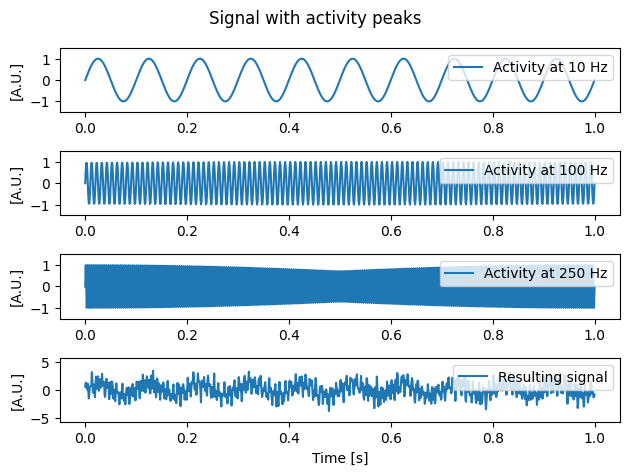

In [29]:
# Settings
frequencies_with_activity = [10, 100, 250]  # Frequencies that will have a peak of activity [Hz]
activity_amplitude = 1                      # Amplitude of the activity peak [A.U.]
noise_amplitude = 0.5                       # Amplitude of the noise [A.U.]
signal_duration = 1                         # Duration of the signal [s]
sampling_frequency = 1000                   # Sampling frequency [Hz]

# Create the time series
# - Time vector, signal matrixm and noise
time = np.linspace(0, signal_duration, signal_duration * sampling_frequency)    # Time vector [s]
signal = np.zeros((len(frequencies_with_activity), len(time)))                  # Initialize the signal matrix
noise = np.random.normal(0, noise_amplitude, len(time))                         # Noise [A.U.]

# - Sample the signal

# - Create signals with activity peaks
for [f, frequency] in enumerate(frequencies_with_activity):
    signal[f,:] = activity_amplitude * np.sin(2 * np.pi * frequency * time)

# - Create the resulting signal
signal_with_noise = np.sum(signal, axis=0) + noise
max_amplitude = np.max(np.abs(signal_with_noise))   # Max amplitude for plot limit

# Plot signals
# - Create the figure and axis
[fig, ax] = plt.subplots(len(frequencies_with_activity)+1, 1)

# - Plot individual signals
for [f, frequency] in enumerate(frequencies_with_activity):
    ax[f].plot(time, signal[f,:], label=f"Activity at {frequency} Hz")
    ax[f].set_ylim([-activity_amplitude*1.5, activity_amplitude*1.5])
    ax[f].set_ylabel("[A.U.]")
    ax[f].legend(loc="upper right")


# - Plot the resulting signal
ax[-1].plot(time, signal_with_noise, label="Resulting signal")
ax[-1].set_ylim([-max_amplitude*1.5, max_amplitude*1.5])
ax[-1].set_xlabel("Time [s]")
ax[-1].set_ylabel("[A.U.]")
ax[-1].legend(loc="upper right")

fig.suptitle('Signal with activity peaks')
fig.tight_layout()

## Frequency domain
Now we will convert the time series into its frequency domain representation 

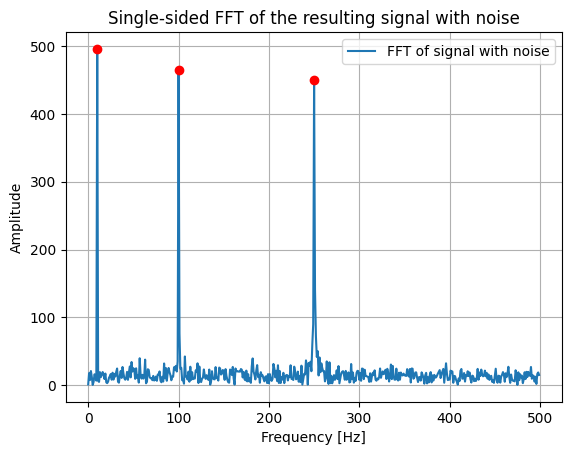

In [30]:
# Calculate the FFT
fft_result = np.fft.fft(signal_with_noise)
fft_freq = np.fft.fftfreq(len(signal_with_noise), d=1/sampling_frequency)

# Take the single-sided FFT
single_sided_fft = np.abs(fft_result[:len(fft_result)//2])
single_sided_freq = fft_freq[:len(fft_freq)//2]

# Plot the FFT
plt.figure()
plt.plot(single_sided_freq, single_sided_fft, label='FFT of signal with noise')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Single-sided FFT of the resulting signal with noise')

# Mark the frequencies with activity
for frequency in frequencies_with_activity:
    plt.plot(frequency, single_sided_fft[np.argmin(np.abs(single_sided_freq - frequency))], 'ro')
    plt.grid()

plt.legend()
plt.show()

## Filters
We will now compute a few different types of filters so see how they affect the resulting signal.
In the next subsections you'll be able to apply different types of filters with set orders, responses, and cut-off frequencies ($f_c$).

### Digital Butterworth filters

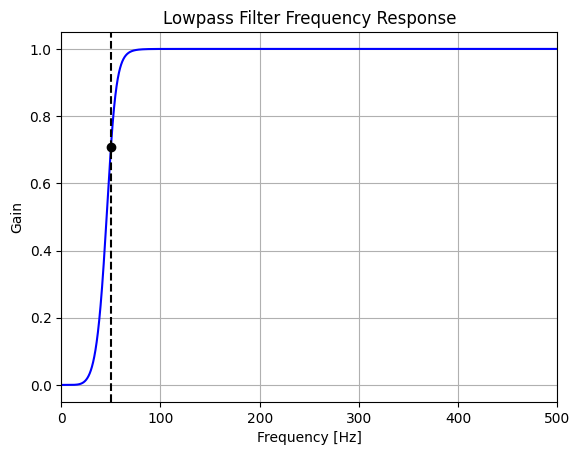

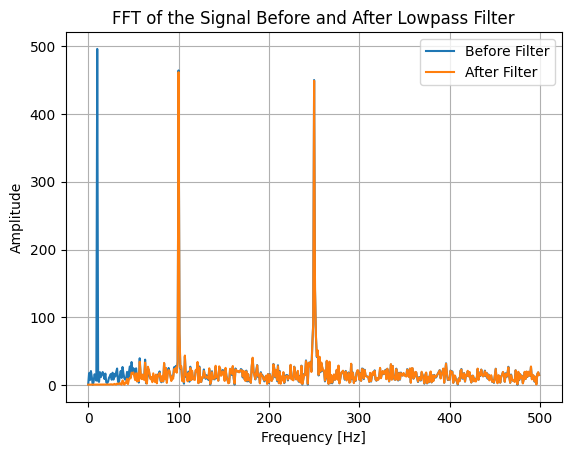

In [45]:
# Filter settings
order = 6                   # Desired order of the filter [n]
cutoff_frequency = 50       # Desired cutoff frequency of the filter [Hz]
filter_type = "highpass"    # Type of filter (lowpass, highpass, bandpass, bandstop)

# Design and apply filter
# - Design digital butterworth lowpass filter
sos = butter(order, cutoff_frequency, btype=filter_type, fs=sampling_frequency, output='sos')

# - Apply the filter to the signal
filtered_signal = sosfilt(sos, signal_with_noise)

# Plots
# - Plot the frequency response of the filter
w, h = sosfreqz(sos, worN=8000, fs=sampling_frequency)
plt.figure()
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff_frequency, 0.5 * np.sqrt(2), 'ko')
plt.axvline(cutoff_frequency, color='k', linestyle='--')
plt.xlim(0, 0.5 * sampling_frequency)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()

# FFT of the filtered signal
fft_filtered_signal = np.fft.fft(filtered_signal)
single_sided_fft_filtered = np.abs(fft_filtered_signal[:len(fft_filtered_signal)//2])

# Plot the FFT before and after the filter
plt.figure()
plt.plot(single_sided_freq, single_sided_fft, label='Before Filter')
plt.plot(single_sided_freq, single_sided_fft_filtered, label='After Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('FFT of the Signal Before and After Lowpass Filter')
plt.legend()
plt.grid()
plt.show()

### Finite impulse reponse filter

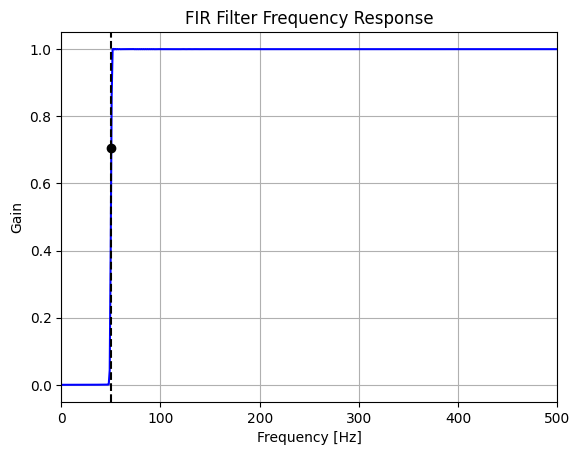

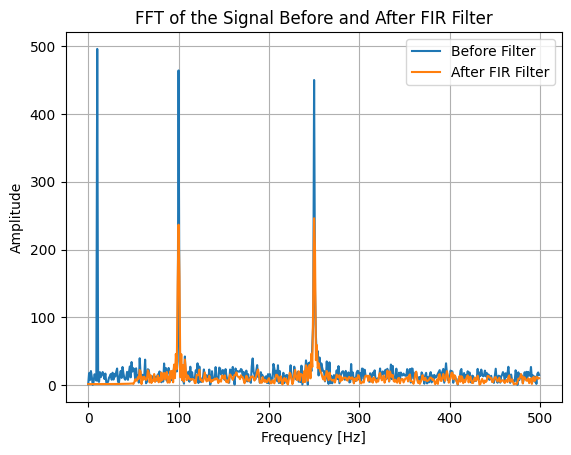

In [49]:
from scipy.signal import firwin, lfilter, freqz

# FIR Filter settings
fir_order = 101                # Order of the FIR filter
fir_cutoff_frequency = 50      # Desired cutoff frequency of the filter [Hz]
fir_filter_type = "highpass"   # Type of filter (lowpass, highpass, bandpass, bandstop)

# Design and apply FIR filter
# - Design FIR filter
fir_coefficients = firwin(fir_order, fir_cutoff_frequency, pass_zero=fir_filter_type, fs=sampling_frequency)

# - Apply the FIR filter to the signal
fir_filtered_signal = lfilter(fir_coefficients, 1.0, signal_with_noise)

# Plots
# - Plot the frequency response of the FIR filter
w, h = freqz(fir_coefficients, fs=sampling_frequency)
plt.figure()
plt.plot(w, np.abs(h), 'b')
plt.plot(fir_cutoff_frequency, 0.5 * np.sqrt(2), 'ko')
plt.axvline(fir_cutoff_frequency, color='k', linestyle='--')
plt.xlim(0, 0.5 * sampling_frequency)
plt.title("FIR Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()

# - FFT of the FIR filtered signal
fft_fir_filtered_signal = np.fft.fft(fir_filtered_signal)
single_sided_fft_fir_filtered = np.abs(fft_fir_filtered_signal[:len(fft_fir_filtered_signal)//2])

# - Plot the FFT before and after the FIR filter
plt.figure()
plt.plot(single_sided_freq, single_sided_fft, label='Before Filter')
plt.plot(single_sided_freq, single_sided_fft_fir_filtered, label='After FIR Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('FFT of the Signal Before and After FIR Filter')
plt.legend()
plt.grid()
plt.show()

### Infinite impulse response filter


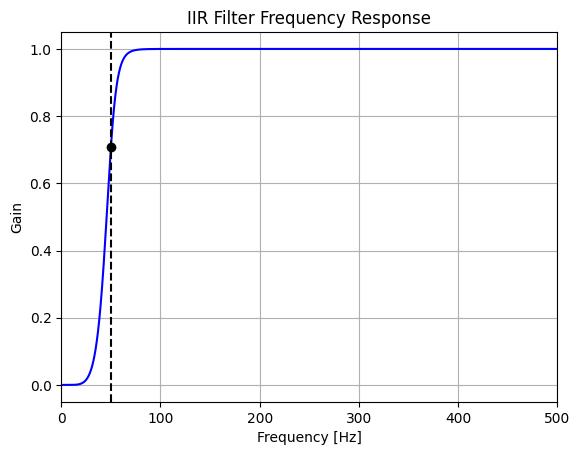

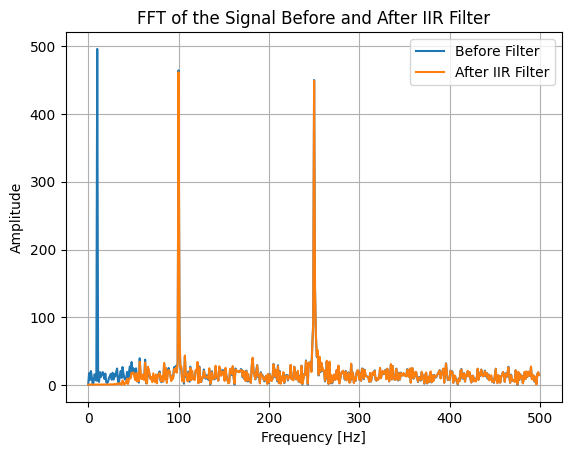

In [50]:
from scipy.signal import iirfilter, sosfilt, sosfreqz

# IIR Filter settings
iir_order = 6                    # Order of the IIR filter
iir_cutoff_frequency = 50        # Desired cutoff frequency of the filter [Hz]
iir_filter_type = "highpass"     # Type of filter (lowpass, highpass, bandpass, bandstop)

# Design and apply IIR filter
# - Design IIR filter
sos_iir = iirfilter(iir_order, iir_cutoff_frequency, btype=iir_filter_type, fs=sampling_frequency, output='sos')

# - Apply the IIR filter to the signal
iir_filtered_signal = sosfilt(sos_iir, signal_with_noise)

# Plots
# - Plot the frequency response of the IIR filter
w_iir, h_iir = sosfreqz(sos_iir, worN=8000, fs=sampling_frequency)
plt.figure()
plt.plot(w_iir, np.abs(h_iir), 'b')
plt.plot(iir_cutoff_frequency, 0.5 * np.sqrt(2), 'ko')
plt.axvline(iir_cutoff_frequency, color='k', linestyle='--')
plt.xlim(0, 0.5 * sampling_frequency)
plt.title("IIR Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()

# - FFT of the IIR filtered signal
fft_iir_filtered_signal = np.fft.fft(iir_filtered_signal)
single_sided_fft_iir_filtered = np.abs(fft_iir_filtered_signal[:len(fft_iir_filtered_signal)//2])

# - Plot the FFT before and after the IIR filter
plt.figure()
plt.plot(single_sided_freq, single_sided_fft, label='Before Filter')
plt.plot(single_sided_freq, single_sided_fft_iir_filtered, label='After IIR Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('FFT of the Signal Before and After IIR Filter')
plt.legend()
plt.grid()
plt.show()